# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
from ddpg_agent import Agent

import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

### 3. Training the agent!

Now it's your turn to train the agent to solve the environment!

In [5]:
def train_agent(n_episodes=300, max_t=500):
    avg_score = []
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    time_steps = 20
    update = 10

    env_info = env.reset(train_mode=True)[brain_name]
    
    states = env_info.vector_observations
    
    agent_tuple = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_tuple) for _ in range(num_agents)]
    action = [agent.act(states[i]) for i, agent in enumerate(agents)]   
    
    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations                 
        for agent in agents:
            agent.reset()

        for t in range(max_t):
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                       
            
            step_t = zip(agents, states, actions, rewards, next_states, dones)
            
            for agent, state, action, reward, next_step, done in step_t:
                agent.memory.add(state, action, reward, next_step, done)
                if ( t % time_steps == 0):
                    agent.step(state, action, reward, next_step, done, update)
            states  = next_states
            scores += rewards                                  
            if np.any(dones):                                 
                break
                
        score = np.mean(scores)        
        avg_score.append(score)
        scores_deque.append(score)
        avg = np.mean(scores_deque)            
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg,), end="\n")

        if avg >= 30:
            print("\r\rEnviroment solved in @ i_episode={i_episode}, w/ avg_score={avg:.2f}\r".format(i_episode=i_episode, avg=avg))
            break

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    
    return avg_score

In [6]:
scores = train_agent()

Episode 1	Average Score: 0.18
Episode 2	Average Score: 0.30
Episode 3	Average Score: 0.34
Episode 4	Average Score: 0.40
Episode 5	Average Score: 0.46
Episode 6	Average Score: 0.51
Episode 7	Average Score: 0.57
Episode 8	Average Score: 0.63
Episode 9	Average Score: 0.68
Episode 10	Average Score: 0.74
Episode 11	Average Score: 0.82
Episode 12	Average Score: 0.89
Episode 13	Average Score: 0.96
Episode 14	Average Score: 1.03
Episode 15	Average Score: 1.10
Episode 16	Average Score: 1.17
Episode 17	Average Score: 1.24
Episode 18	Average Score: 1.30
Episode 19	Average Score: 1.37
Episode 20	Average Score: 1.45
Episode 21	Average Score: 1.51
Episode 22	Average Score: 1.59
Episode 23	Average Score: 1.67
Episode 24	Average Score: 1.74
Episode 25	Average Score: 1.81
Episode 26	Average Score: 1.89
Episode 27	Average Score: 1.96
Episode 28	Average Score: 2.04
Episode 29	Average Score: 2.13
Episode 30	Average Score: 2.21
Episode 31	Average Score: 2.29
Episode 32	Average Score: 2.38
Episode 33	Averag

In [7]:
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

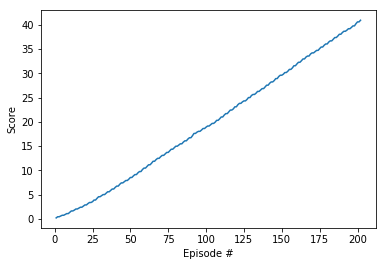

In [8]:
plot_scores(scores)